In [1]:
# Import Liblary yang akan digunakan
import os
import Augmentor
import zipfile
import random
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [ ]:
AugmentData("Dataset 2/Gigi/", 1000)

In [ ]:
AugmentData("Dataset 2/Bukan Gigi/", 1000)

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Gigi_SOURCE_DIR = "Dataset 2/Gigi/"
BukanGigi_SOURCE_DIR = "Dataset 2/Bukan Gigi/"

TRAINING_Gigi_DIR = "Dataset_Real 2/training/Gigi/"
TRAINING_BukanGigi_DIR = "Dataset_Real 2/training/Bukan Gigi/"

TESTING_Gigi_DIR = "Dataset_Real 2/testing/Gigi/"
TESTING_BukanGigi_DIR = "Dataset_Real 2/testing/Bukan Gigi/"

split_size = .8
split_data(Gigi_SOURCE_DIR, TRAINING_Gigi_DIR, TESTING_Gigi_DIR, split_size)
split_data(BukanGigi_SOURCE_DIR, TRAINING_BukanGigi_DIR, TESTING_BukanGigi_DIR, split_size)

In [53]:
TRAINING_DIR = "Dataset_Real 2/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "Dataset_Real 2/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [54]:
validation_generator.num_classes

2

In [55]:
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, input_shape)
validation_data = tf_data_generator(validation_generator, input_shape)

In [56]:
print(train_data)
print(validation_data)

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<FlatMapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [90]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 128)     

In [91]:
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['accuracy'])

In [94]:
# Note that this may take some time.
history = model.fit(train_data,
                    steps_per_epoch=40,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_data,
                    validation_steps=20)

Epoch 1/10
40/40 [==============================] - 5s 123ms/step - loss: 0.2758 - accuracy: 0.8938 - val_loss: 0.0874 - val_accuracy: 0.9550
Epoch 2/10
40/40 [==============================] - 5s 121ms/step - loss: 0.1124 - accuracy: 0.9588 - val_loss: 0.2536 - val_accuracy: 0.9100
Epoch 3/10
40/40 [==============================] - 5s 120ms/step - loss: 0.0890 - accuracy: 0.9625 - val_loss: 0.1465 - val_accuracy: 0.9400
Epoch 4/10
40/40 [==============================] - 5s 120ms/step - loss: 0.0757 - accuracy: 0.9750 - val_loss: 0.0458 - val_accuracy: 0.9850
Epoch 5/10
40/40 [==============================] - 5s 120ms/step - loss: 0.0599 - accuracy: 0.9762 - val_loss: 0.1152 - val_accuracy: 0.9650
Epoch 6/10
40/40 [==============================] - 5s 121ms/step - loss: 0.0415 - accuracy: 0.9812 - val_loss: 0.0174 - val_accuracy: 0.9900
Epoch 7/10
40/40 [==============================] - 5s 121ms/step - loss: 0.0720 - accuracy: 0.9762 - val_loss: 0.0668 - val_accuracy: 0.9850
Epoch 

In [95]:
model.evaluate(validation_generator)

40/40 [==============================] - 2s 39ms/step - loss: 0.0117 - accuracy: 0.9950


[0.011713759042322636, 0.9950000047683716]

In [96]:
#classes 
class_names =  ["Bukan Gigi", "Gigi"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Bukan Gigi   0
Gigi   1


[0]
bukan_gigi 4.jpg bukan gigi


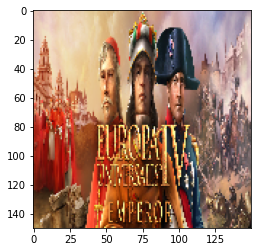

In [97]:
path = "bukan_gigi 4.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
prediction = np.argmax(classes,axis=1)
print(prediction)
if prediction[0]>0.5:
    print(path + " adalah gigi")
else:
    print(path + " bukan gigi")
    
plt.imshow(img)

[9.9999988e-01 6.0447384e-08]
Prediksi : Bukan Gigi
Persentase Keyakinan : 100.00 %



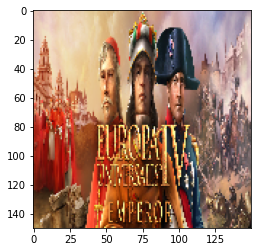

In [98]:
path = "bukan_gigi 4.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
prediction = np.argmax(classes,axis=1)
print(classes[0])

print("Prediksi : {}".format(class_names[prediction[0]]))
print("Persentase Keyakinan : {:.2f} %\n".format(np.max(classes) * 100))
plt.imshow(img)

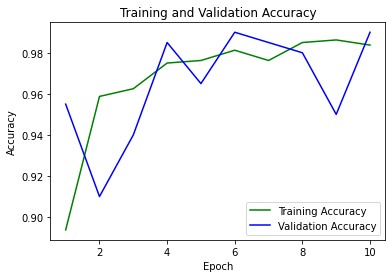

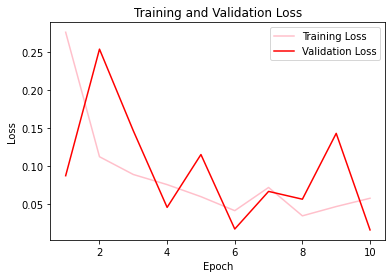

In [99]:
#plotting training values

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [100]:
export_dir = 'saved_model/2 - Gigi Bukan Gigi/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/2 - Gigi Bukan Gigi/assets


INFO:tensorflow:Assets written to: saved_model/2 - Gigi Bukan Gigi/assets


In [101]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [102]:
tflite_model_file = pathlib.Path('./model-gigiBukanGigiv2.0.tflite')
tflite_model_file.write_bytes(tflite_model)

76219820

In [103]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [104]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

[1. 0.]
[0]
Prediksi : Bukan Gigi
Persentase Keyakinan : 100.00 %



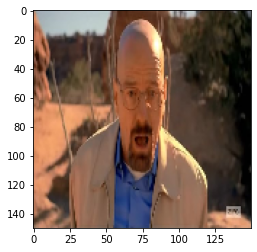

In [134]:
image_path = "bukan_gigi 5.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
rflite_results = interpreter.get_tensor(output_details[0]['index'])
print(rflite_results[0])
prediction = np.argmax(rflite_results,axis=1)
print(prediction)

print("Prediksi : {}".format(class_names[prediction[0]]))
print("Persentase Keyakinan : {:.2f} %\n".format(np.max(classes) * 100))

plt.imshow(new_img)

In [127]:
image_path = "bukan_gigi 2.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)/255
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
rflite_results = interpreter.get_tensor(output_details[0]['index'])
print(rflite_results[0])
if rflite_results[0]>0.5:
    print(image_path + " adalah gigi")
else:
    print(image_path + " bukan gigi")
plt.imshow(new_img)

[9.9982661e-01 1.7336104e-04]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
print(input_details)
print(output_details)

[{'name': 'serving_default_conv2d_3_input:0', 'index': 0, 'shape': array([  1, 150, 150,   3]), 'shape_signature': array([ -1, 150, 150,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
